# Install Libraries if Needed (Only Run Once)

In [10]:
# !nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:13:23_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [12]:
# !pip install -U jax[cuda] --user

  Using cached jax-0.2.25-py3-none-any.whl
  Using cached jax-0.2.24.tar.gz (786 kB)
  Preparing metadata (setup.py) ... done


In [3]:
# !pip install -U deepxde
# !pip install matplotlib
# !pip install numpy
# !pip install scipy
# !pip install -U tensorflow
# !pip install ipympl
# !pip install torch


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://storage.googleapis.com/jax-releases/jax_releases.html
  Using cached jax-0.2.25.tar.gz (786 kB)
  Preparing metadata (setup.py) ... done
  Using cached jax-0.2.24.tar.gz (786 kB)
  Preparing metadata (setup.py) ... done
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [66]:
# !pip install -U ipython

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 790 kB 14.6 MB/s            


# Import Libraries

In [1]:
# Interactive Plotting

# for jupyter notebooks
%matplotlib notebook 

# for jupyter labs
# %matplotlib widget 

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import io
import re


import os
import jax
import jax.numpy as jnp
import numpy as np
import torch
from jax import random, grad, vmap, jit, hessian
from jax.experimental import optimizers
from jax.experimental.optimizers import adam, exponential_decay
from jax.experimental.ode import odeint
from jax.nn import relu, elu, softplus
from jax.config import config
from jax.ops import index_update, index
from jax import lax
from jax.lax import while_loop, scan, cond
from jax.flatten_util import ravel_pytree

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from torch.utils import data


import sys


# Intro To Jax

This notebook is written in Jax.  Jax is essentially numpy on steroids.  It can map numpy function to GPU/TPU devices with only some slight differences.  It allow provides automatic differentiation.  Working with a low level library like Jax makes some physics informed deep learning applications easier.

See https://github.com/google/jax for more details.

# Base Classes

## Jax Layers

In [3]:

# Define MLP
def MLP(layers, activation=relu):
  ''' Vanilla MLP'''
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / jnp.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = jnp.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = jnp.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = jnp.dot(inputs, W) + b
      return outputs
  return init, apply

# Define modified MLP
def modified_MLP(layers, activation=relu):
  def xavier_init(key, d_in, d_out):
      glorot_stddev = 1. / jnp.sqrt((d_in + d_out) / 2.)
      W = glorot_stddev * random.normal(key, (d_in, d_out))
      b = jnp.zeros(d_out)
      return W, b

  def init(rng_key):
      U1, b1 =  xavier_init(random.PRNGKey(12345), layers[0], layers[1])
      U2, b2 =  xavier_init(random.PRNGKey(54321), layers[0], layers[1])
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          W, b = xavier_init(k1, d_in, d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return (params, U1, b1, U2, b2) 

  def apply(params, inputs):
      params, U1, b1, U2, b2 = params
      U = activation(jnp.dot(inputs, U1) + b1)
      V = activation(jnp.dot(inputs, U2) + b2)
      for W, b in params[:-1]:
          outputs = activation(jnp.dot(inputs, W) + b)
          inputs = jnp.multiply(outputs, U) + jnp.multiply(1 - outputs, V) 
      W, b = params[-1]
      outputs = jnp.dot(inputs, W) + b
      return outputs
  return init, apply

# Define Fourier feature net
def FF_MLP(layers, freqs=50, activation=relu):
   # Define input encoding function
    def input_encoding(x, w):
        out = jnp.hstack([jnp.sin(jnp.dot(x, w)),
                         jnp.cos(jnp.dot(x, w))])
        return out
    FF = freqs * random.normal(random.PRNGKey(0), (layers[0], layers[1]//2))
    def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / jnp.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = jnp.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[1:-1], layers[2:]))
      return params
    def apply(params, inputs):
        H = input_encoding(inputs, FF)
        for W, b in params[:-1]:
            outputs = jnp.dot(H, W) + b
            H = activation(outputs)
        W, b = params[-1]
        outputs = jnp.dot(H, W) + b
        return outputs
    return init, apply


## DataLoader

In [4]:

# Data generator
class DataGenerator(data.Dataset):
    def __init__(self, u, y, s, 
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u # input sample
        self.y = y # location
        self.s = s # labeled data evulated at y (solution measurements, BC/IC conditions, etc.)
        
        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        if self.batch_size <= self.N:
            idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        else:
            idx = random.choice(key, self.N, (self.N,), replace=False)
        s = self.s[idx,:]
        y = self.y[idx,:]
        u = self.u[idx,:]
        # Construct batch
        inputs = (u, y)
        outputs = s
        return inputs, outputs
    
    
# Data generator
class DataGeneratorEfficient(data.Dataset):
    def __init__(self, u, y, s, ind,
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        
        self.u = u # input sample (Nsim, m)
        self.y = y # location
        self.s = s # labeled data evulated at y (solution measurements, BC/IC conditions, etc.)
        self.ind = ind  # int array representing which coordinate belongs with which u
        self.N = y.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        if self.batch_size <= self.N:
            idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        else:
            idx = random.choice(key, self.N, (self.N,), replace=False)
        s = self.s[idx,:]
        y = self.y[idx,:]
        ind = self.ind[idx,0] # reshapes ind correctly for indexing u
        u = self.u[ind,:]
        # Construct batch
        inputs = (u, y)
        outputs = s
        return inputs, outputs

## DeepONetPI Model (Subclass this model for your particular PDE)

In [5]:

# Define the model
class DeepONetPI:
    def __init__(self, 
                 branch_layers, 
                 trunk_layers, 
                 branch_net=MLP,
                 trunk_net=MLP,
                 branch_activation=jnp.tanh,
                 trunk_activation=jnp.tanh,
                 branch_rng_key=random.PRNGKey(1234),
                 trunk_rng_key=random.PRNGKey(4321),
                 optimizer=adam(exponential_decay(1e-3, decay_steps=5000,decay_rate=0.9)),
                 operator_loss_const=1.0,
                 physics_loss_const=1.0,
                 bcs_loss_const=1.0,
                 ics_loss_const=1.0,
                 ckpt_dir='DeepONetPI',
                 ckpt_file='params.npy',
                 it_file='iterations.npy',
                 loss_file='loss.npy',
                 loss_operator_file='loss_operator.npy',
                 loss_physics_file='loss_physics.npy',
                 loss_bcs_file='loss_bcs.npy',
                 loss_ics_file='loss_ics.npy',
                 ):
        # Network initialization and evaluation functions
        # These are reserved for the flax case
        self.branch_net = None
        self.trunk_net = None
        # Branch network
        self.branch_init, self.branch_apply = branch_net(branch_layers, activation=branch_activation)
        # Trunk network
        self.trunk_init, self.trunk_apply = trunk_net(trunk_layers, activation=trunk_activation)

        # Initialize
        branch_params = self.branch_init(rng_key=branch_rng_key)
        trunk_params = self.trunk_init(rng_key=trunk_rng_key)
        params = (branch_params, trunk_params)

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, self.opt_update, self.get_params = optimizer
        self.opt_state = self.opt_init(params)

        # Initialize itercounter
        self.itercount = itertools.count()
        self.it = 0
        
        # Get Number of coordinate dimensions
        self.dim = trunk_layers[0]
        
         # Used to restore the trained model parameters
        _, self.unravel_params = ravel_pytree(params)
        
        
        # Define loss constants used to weight the loss
        self.operator_loss_const = operator_loss_const
        self.physics_loss_const = physics_loss_const
        self.bcs_loss_const = bcs_loss_const
        self.ics_loss_const = ics_loss_const
        
        # Loggers
        self.loss_log = []
        self.loss_operator_log = []
        self.loss_physics_log = []
        self.loss_bcs_log = []
        self.loss_ics_log = []
        
        # Checkpointing file names
        self.ckpt_dir = ckpt_dir
        self.ckpt_path = os.path.join(self.ckpt_dir, ckpt_file)
        self.it_path = os.path.join(self.ckpt_dir, it_file)
        self.loss_path = os.path.join(self.ckpt_dir, loss_file)
        self.loss_operator_path = os.path.join(self.ckpt_dir, loss_operator_file)
        self.loss_physics_path = os.path.join(self.ckpt_dir, loss_physics_file)
        self.loss_bcs_path = os.path.join(self.ckpt_dir, loss_bcs_file)
        self.loss_ics_path = os.path.join(self.ckpt_dir, loss_ics_file)

        
    # Define DeepONet architecture
    def operator_net(self, params, u, *y):
        # Apply DeepONet
        # inputs: (u, *y), shape = (N, m), (N, 1) * dim or (N, dim)
        # outputs: s, shape = (N, 1)
        # Note that each coordinate dimension can be a separate input or a single array. This is done to make differentiation easier. In future we may allow u to be a tuple of shapes (N, m_i) * len(u) to allow for multiple branch networks to represent ics, bcs, 
        
        y = jnp.stack(y)
        branch_params, trunk_params = params
        B = self.branch_apply(branch_params, u)
        T = self.trunk_apply(trunk_params, y)
        outputs = jnp.sum(B * T)
        return outputs
    
    # Define ODE/PDE residual (initial definition)
    def pde_net(self, params, u, y):
        # s_ = self.operator_net # shorthand for operator_net function call
        # s = s_(params, u, y) # actual value of s (may not be needed)
        # # optionally split s up here       
        # s_y = grad(s_, 2)(params, u, y) # the 2nd argument in grad specifies the argument number, here y is 2 for example
        # res = 0.0 # here we output 0 because we want the user to specify the pde
        # return res
        pass
    
    # Define boundary condition (initial definition)
    def bc_net(self, params, u, y):
        pass
    
    # Define initial condition (initial definition)
    def ic_net(self, params, u, y):
        pass
    
    # Define operator loss
    def loss_operator(self, params, batch):
        # Fetch data
        # inputs: (u, y), shape = (N, m), (N, dim)
        # outputs: s, shape = (N, 1)
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        pred = vmap(self.operator_net, (None, 0, 0))(params, u, y)
        # Compute loss
        loss = jnp.mean((outputs.flatten() - pred.flatten())**2)
        return loss

    # Define physics loss
    def loss_physics(self, params, batch):
        # Fetch data
        # inputs: (u_pde, y_pde), shape = (N_pde, m), (N_pde, dim)
        # outputs: s_pde, shape = (N_pde, 1)
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        pred = vmap(self.pde_net, (None, 0, 0))(params, u, y)
        # Compute loss
        loss = jnp.mean((outputs.flatten() - pred.flatten())**2)
        return loss
    
    def loss_bcs(self, params, batch):
        # Fetch data
        # inputs: (u_bc, y_bc), shape = (N_bc, m), (N_bc, dim)
        # outputs: s_bc, shape = (N_bc, 1)
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        pred = vmap(self.bc_net, (None, 0, 0))(params, u, y)
        # Compute loss
        loss = jnp.mean((outputs.flatten() - pred.flatten())**2)
        return loss
    
    def loss_ics(self, params, batch):
        # Fetch data
        # inputs: (u_ic, y_ic), shape = (N_ic, m), (N_ic, dim)
        # outputs: s_ic, shape = (N_ic, 1)
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        pred = vmap(self.ic_net, (None, 0, 0))(params, u, y)
        # Compute loss
        loss = jnp.mean((outputs.flatten() - pred.flatten())**2)
        return loss
    
    # Define total loss
    def loss(self, params, operator_batch=None, physics_batch=None, bcs_batch=None, ics_batch=None):
        loss = loss_operator = loss_physics = loss_bcs = loss_ics = 0.0
        # lax.cond(operator_batch is not None, )
        if operator_batch is not None:
            loss_operator = self.loss_operator(params, operator_batch)
        if physics_batch is not None:
            loss_physics = self.loss_physics(params, physics_batch)
        if bcs_batch is not None:
            loss_bcs = self.loss_bcs(params, bcs_batch)
        if ics_batch is not None:
            loss_ics = self.loss_ics(params, ics_batch)
        # losses = jnp.array([loss_operator, loss_physics, loss_bcs, loss_ics])
        # loss = jnp.nansum(losses)
        
        loss = self.operator_loss_const*loss_operator + self.physics_loss_const*loss_physics + self.bcs_loss_const*loss_bcs + self.ics_loss_const*loss_ics
        return loss

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, operator_batch=None, physics_batch=None, bcs_batch=None, ics_batch=None):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, operator_batch, physics_batch, bcs_batch, ics_batch)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, 
              operator_dataset=None, 
              physics_dataset=None, 
              bcs_dataset=None, 
              ics_dataset=None,
              operator_val_dataset=None, 
              physics_val_dataset=None,
              bcs_val_dataset=None,
              ics_val_dataset=None,
              operator_loss_const=None,
              physics_loss_const=None,
              bcs_loss_const=None,
              ics_loss_const=None,
              nIter=10000, 
              log_freq=10, 
              val_freq=10,
              ckpt_freq=1000,
              history_freq=1000):
        
        # Update loss constants if desired
        if operator_loss_const is not None:
            self.operator_loss_const = operator_loss_const
        if physics_loss_const is not None:
            self.physics_loss_const = physics_loss_const
        if bcs_loss_const is not None:
            self.bcs_loss_const = bcs_loss_const
        if ics_loss_const is not None:
            self.ics_loss_const = ics_loss_const
            
        # Define the data iterator
        operator_data = physics_data = ics_data = bcs_data = None
        if operator_dataset is not None:
            operator_data = iter(operator_dataset)
        if physics_dataset is not None:
            physics_data = iter(physics_dataset)
        if bcs_dataset is not None:
            bcs_data = iter(bcs_dataset)
        if ics_dataset is not None:
            ics_data = iter(ics_dataset)

        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            operator_batch = physics_batch = bcs_batch = ics_batch = None
            if operator_data is not None:
                operator_batch = next(operator_data)
            if physics_data is not None:
                physics_batch = next(physics_data)
            if bcs_data is not None:
                bcs_batch = next(bcs_data)
            if ics_data is not None:
                ics_batch = next(ics_data)
            # current iteration including past training
            self.it = next(self.itercount)
            self.opt_state = self.step(self.it, self.opt_state, operator_batch, physics_batch, bcs_batch, ics_batch)
            
            if (log_freq != 0) and (it % log_freq == 0):
                params = self.get_params(self.opt_state)

                # Compute losses
                loss_value = self.loss(params, operator_batch, physics_batch, bcs_batch, ics_batch)
                
                if operator_batch is not None:
                    loss_operator_value = self.loss_operator(params, operator_batch)
                else:
                    loss_operator_value = None
                if physics_batch is not None:
                    loss_physics_value = self.loss_physics(params, physics_batch)
                else:
                    loss_physics_value = None
                if bcs_batch is not None:
                    loss_bcs_value = self.loss_bcs(params, bcs_batch)
                else:
                    loss_bcs_value = None
                if ics_batch is not None:
                    loss_ics_value = self.loss_ics(params, ics_batch)
                else:
                    loss_ics_value = None
                

                # Store losses
                loss_dict = {} # for printing losses in pbar
                if loss_value is not None:
                    self.loss_log.append([self.it, loss_value])
                    loss_dict['loss'] = loss_value                    
                if loss_operator_value is not None:
                    self.loss_operator_log.append([self.it, loss_operator_value])
                    loss_dict['loss_operator'] = loss_operator_value
                if loss_physics_value is not None:
                    self.loss_physics_log.append([self.it, loss_physics_value])
                    loss_dict['loss_physics'] = loss_physics_value
                if loss_bcs_value is not None:
                    self.loss_bcs_log.append([self.it, loss_bcs_value])
                    loss_dict['loss_bcs'] = loss_bcs_value
                if loss_ics_value is not None:
                    self.loss_ics_log.append([self.it, loss_ics_value])
                    loss_dict['loss_ics'] = loss_ics_value

                # Print losses during training
                pbar.set_postfix(loss_dict)
            
            if (ckpt_freq != 0) and (it % ckpt_freq == 0):
                # may want to add an iteration number to ckpt_path in future
                self.save(ckpt_path=self.ckpt_path, it_path=self.it_path)
                
            if (history_freq != 0) and (it % history_freq == 0):
                # may want to add an itteration number to the loss logs in future
                self.save_history()
                
    def save(self, ckpt_path=None, it_path=None):
        if ckpt_path is None:
            ckpt_path = self.ckpt_path
        if it_path is None:
            it_path = self.it_path
        ckpt_dir = os.path.split(ckpt_path)[0]
        os.makedirs(ckpt_dir, exist_ok=True)
        params = self.get_params(self.opt_state) 
        flat_params = flat_params, _  = ravel_pytree(params)
        jnp.save(ckpt_path, flat_params)
        jnp.save(it_path, self.it)
        
    def restore(self, ckpt_path=None, it_path=None):
        if ckpt_path is None:
            ckpt_path = self.ckpt_path
        if it_path is None:
            it_path = self.it_path
        try:
            flat_params = jnp.load(ckpt_path)
        except:
            print(f'Failed to load file {ckpt_path}')
            traceback.print_exc()
            return
        try:
            self.it = int(jnp.load(it_path))
        except:
            print(f'Failed to load file {it_path}')
            traceback.print_exc()
        params = self.unravel_params(flat_params)
        self.opt_state = self.opt_init(params)
        # note that we neet to initialize itercount value (initializes to current iteration, but we want next iteration for training)
        self.itercount = itertools.count(self.it)
        self.it = next(self.itercount)

    def save_history(self, loss_path=None, loss_operator_path=None, loss_physics_path=None, loss_bcs_path=None, loss_ics_path=None):
        if loss_path is None:
            loss_path = self.loss_path
        if loss_operator_path is None:
            loss_operator_path = self.loss_operator_path
        if loss_physics_path is None:
            loss_physics_path = self.loss_physics_path
        if loss_bcs_path is None:
            loss_bcs_path = self.loss_bcs_path
        if loss_ics_path is None:
            loss_ics_path = self.loss_ics_path
        
        loss_dir = os.path.split(loss_path)[0]
        loss_operator_dir = os.path.split(loss_operator_path)[0]
        loss_physics_dir = os.path.split(loss_physics_path)[0]
        loss_bcs_dir = os.path.split(loss_bcs_path)[0]
        loss_ics_dir = os.path.split(loss_ics_path)[0]
        
        if self.loss_log:
            os.makedirs(loss_dir, exist_ok=True)
            jnp.save(loss_path, self.loss_log)
        if self.loss_operator_log:
            os.makedirs(loss_operator_dir, exist_ok=True)
            jnp.save(loss_operator_path, self.loss_operator_log)
        if self.loss_physics_log:
            os.makedirs(loss_physics_dir, exist_ok=True)
            jnp.save(loss_physics_path, self.loss_physics_log)
        if self.loss_bcs_log:
            os.makedirs(loss_bcs_dir, exist_ok=True)
            jnp.save(loss_bcs_path, self.loss_bcs_log)
        if self.loss_ics_log:
            os.makedirs(loss_ics_dir, exist_ok=True)
            jnp.save(loss_ics_path, self.loss_ics_log)
            
    def restore_history(self, loss_path=None, loss_operator_path=None, loss_physics_path=None, loss_bcs_path=None, loss_ics_path=None):
        if loss_path is None:
            loss_path = self.loss_path
        if loss_operator_path is None:
            loss_operator_path = self.loss_operator_path
        if loss_physics_path is None:
            loss_physics_path = self.loss_physics_path
        if loss_bcs_path is None:
            loss_bcs_path = self.loss_bcs_path
        if loss_ics_path is None:
            loss_ics_path = self.loss_ics_path
        
        # Try to load the loss files and add them to loss logs.  It is ok if they fail beacause the loss files might not exist.
        try:
            loss_log = jnp.load(loss_path)
            self.loss_log = list(list(l) for l in loss_log)
        except:
            print(f'Failed to load file {loss_path}')
        try:
            loss_operator_log = jnp.load(loss_operator_path)
            self.loss_operator_log = list(list(l) for l in loss_operator_log)
        except:
            print(f'Failed to load file {loss_operator_path}')
        try:
            loss_physics_log = jnp.load(loss_physics_path)
            self.loss_physics_log = list(list(l) for l in loss_physics_log)
        except:
            print(f'Failed to load file {loss_physics_path}')
        try:
            loss_bcs_log = jnp.load(loss_bcs_path)
            self.loss_bcs_log = list(list(l) for l in loss_bcs_log)
        except:
            print(f'Failed to load file {loss_bcs_path}')
        try:
            loss_ics_log = jnp.load(loss_ics_path)
            self.loss_ics_log = list(list(l) for l in loss_ics_log)
        except:
            print(f'Failed to load file {loss_ics_path}')
        
    def restart_counter(self, i=0):
        self.itercount = itertools(i)
       
           
    # Evaluates predictions at test points  
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, U_star, Y_star):
        s_pred = vmap(self.operator_net, (None, 0, 0))(params, U_star, Y_star)
        return s_pred

    @partial(jit, static_argnums=(0,))
    def predict_pde(self, params, U_star, Y_star):
        pde_pred = vmap(self.pde_net, (None, 0, 0))(params, U_star, Y_star)
        return pde_pred
    
    

## Utilities 

In [6]:
# Use double precision to generate data (due to GP sampling)
def RBF(x1, x2, params):
    output_scale, lengthscales = params
    diffs = jnp.expand_dims(x1 / lengthscales, 1) - \
            jnp.expand_dims(x2 / lengthscales, 0)
    r2 = jnp.sum(diffs**2, axis=2)
    return output_scale * jnp.exp(-0.5 * r2)

# Diffusion Reaction Equation
$$
\frac{\partial s}{\partial t}=D \frac{\partial^{2} s}{\partial x^{2}}+k s^{2}+u(x), \quad x \in(0,1), t \in(0,1],\\
s(0,t) = s(1,t) = s(x,0) = 0, \\
k=D=0.01
$$


# Define Network

In [7]:
class DRDeepONetPI(DeepONetPI):
    def __init__(self,
                 branch_layers, 
                 trunk_layers, 
                 branch_net=MLP,
                 trunk_net=MLP,
                 branch_activation=jnp.tanh,
                 trunk_activation=jnp.tanh,
                 branch_rng_key=random.PRNGKey(1234),
                 trunk_rng_key=random.PRNGKey(4321),
                 optimizer=adam(exponential_decay(1e-3, decay_steps=5000, decay_rate=0.9)),
                 operator_loss_const=1.0,
                 physics_loss_const=1.0,
                 bcs_loss_const=1.0,
                 ics_loss_const=1.0,
                 ckpt_dir='DiffusionReaction',
                 ckpt_file='params.npy',
                 loss_file='loss.npy',
                 loss_operator_file='loss_operator.npy',
                 loss_physics_file='loss_physics.npy',
                 loss_bcs_file='loss_bcs.npy',
                 loss_ics_file='loss_ics.npy',   
                 ):
        super().__init__(branch_layers, 
                         trunk_layers, 
                         branch_net, 
                         trunk_net, 
                         branch_activation, 
                         trunk_activation, 
                         branch_rng_key, 
                         trunk_rng_key, 
                         optimizer, 
                         operator_loss_const, 
                         physics_loss_const, 
                         bcs_loss_const, 
                         ics_loss_const, 
                         ckpt_dir, 
                         ckpt_file, 
                         loss_file, 
                         loss_operator_file, 
                         loss_physics_file, 
                         loss_bcs_file, 
                         loss_ics_file)
        
    def pde_net(self, params, u, y):
        # note that y here can include additional coord not passed to the original operator network
        # print(y.shape)
        x = y[0]
        t = y[1]
        s_ = self.operator_net # shorthand for operator_net function call
        s = s_(params, u, x, t) # actual value of s (may not be needed)
        s_x = grad(s_, 2)(params, u, x, t) 
        s_t = grad(s_, 3)(params, u, x, t)
        s_xx = grad(grad(s_, 2), 2)(params, u, x, t)
        res = s_t - 0.01 * s_xx - 0.01 * s**2 # this is equal to u(x), this avoids the interpolation
        return res
    
    # here we are provided with values for BC/IC (zero), so for this case just call the operator net.  If we had Robin BC for example, we would output an array with outputs of [value, derivative]
    # Also, if we had the case where BC/IC = u, we would return res = s - u
    def bc_net(self, params, u, y):
        s_ = self.operator_net # shorthand for operator_net function call
        s = s_(params, u, y) # actual value of s
        return s
    
    def ic_net(self, params, u, y):
        s_ = self.operator_net # shorthand for operator_net function call
        s = s_(params, u, y) # actual value of s
        return s

# Define Dataset Parameters

In [8]:
# Use double precision to generate data (due to GP sampling)

# A diffusion-reaction numerical solver
def solve_ADR(key, Nx, Nt, N_op, length_scale):
    """Solve 1D
    u_t = (k(x) u_x)_x - v(x) u_x + g(u) + f(x)
    with zero initial and boundary conditions.
    """
    xmin, xmax = 0, 1
    tmin, tmax = 0, 1
    k = lambda x: 0.01*jnp.ones_like(x)
    v = lambda x: jnp.zeros_like(x)
    g = lambda u: 0.01*u ** 2
    dg = lambda u: 0.02 * u
    u0 = lambda x: jnp.zeros_like(x)

    # Generate subkeys
    subkeys = random.split(key, 2)

    # Generate a GP sample
    N = 512
    gp_params = (1.0, length_scale)
    jitter = 1e-10
    X = jnp.linspace(xmin, xmax, N)[:,None]
    K = RBF(X, X, gp_params)
    L = jnp.linalg.cholesky(K + jitter*jnp.eye(N))
    gp_sample = jnp.dot(L, random.normal(subkeys[0], (N,)))
    # Create a callable interpolation function  
    f_fn = lambda x: jnp.interp(x, X.flatten(), gp_sample)

    # Create grid
    x = jnp.linspace(xmin, xmax, Nx)
    t = jnp.linspace(tmin, tmax, Nt)
    h = x[1] - x[0]
    dt = t[1] - t[0]
    h2 = h ** 2

    # Compute coefficients and forcing
    k = k(x)
    v = v(x)
    f = f_fn(x)

    # Compute finite difference operators
    D1 = jnp.eye(Nx, k=1) - jnp.eye(Nx, k=-1)
    D2 = -2 * jnp.eye(Nx) + jnp.eye(Nx, k=-1) + jnp.eye(Nx, k=1)
    D3 = jnp.eye(Nx - 2)
    M = -jnp.diag(D1 @ k) @ D1 - 4 * jnp.diag(k) @ D2
    m_bond = 8 * h2 / dt * D3 + M[1:-1, 1:-1]
    v_bond = 2 * h * jnp.diag(v[1:-1]) @ D1[1:-1, 1:-1] + 2 * h * jnp.diag(
        v[2:] - v[: Nx - 2]
    )
    mv_bond = m_bond + v_bond
    c = 8 * h2 / dt * D3 - M[1:-1, 1:-1] - v_bond

    # Initialize solution and apply initial condition
    u = jnp.zeros((Nx, Nt))
    # u = index_update(u, index[:,0], u0(x)) # this index_update syntax has been decapitated and the new syntax is better
    u = u.at[:, 0].set(u0(x))
    # Time-stepping update
    def body_fn(i, u):
        gi = g(u[1:-1, i])
        dgi = dg(u[1:-1, i])
        h2dgi = jnp.diag(4 * h2 * dgi)
        A = mv_bond - h2dgi
        b1 = 8 * h2 * (0.5 * f[1:-1] + 0.5 * f[1:-1] + gi)
        b2 = (c - h2dgi) @ u[1:-1, i].T
        # u = index_update(u, index[1:-1, i + 1], jnp.linalg.solve(A, b1 + b2)) # this index_update syntax has been decapitated and the new syntax is better
        u = u.at[1:-1, i + 1].set(jnp.linalg.solve(A, b1 + b2))
        return u
    # Run loop
    S = lax.fori_loop(0, Nt-1, body_fn, u)

    # Input sensor locations and measurements
    xx = jnp.linspace(xmin, xmax, m)
    u = f_fn(xx)
    # Output sensor locations and measurements
    idx = random.randint(subkeys[1], (N_op, 2), 0, max(Nx,Nt))
    y = jnp.concatenate([x[idx[:,0]][:,None], t[idx[:,1]][:,None]], axis = 1)
    s = S[idx[:,0], idx[:,1]]
    # x, t: sampled points on grid
    return (x, t, S), (u, y, s)

# Geneate training data corresponding to one input sample
def generate_one_training_data_efficient(key, index, N_op, N_pde, N_bcs, N_ics):
    # Numerical solution
    (x, t, S), (u, y, s) = solve_ADR(key, Nx , Nt, N_op, length_scale)

    # Geneate subkeys
    subkeys = random.split(key, 4)
    
    # Sample the data
    # u_op = jnp.tile(u, (N_op, 1))
    u_op = u
    num_op = jnp.tile(index, (N_op, 1))
    y_op = y
    s_op = s
    
    # Generate data for PDE constraints
    # Sample collocation points
    # Chooses N_pde random points in domain of (x, t).  We don't need to have a correct prediction for solution s, only that our prediction by the ANN satisfies the pde at the specified (x,t). For s, we take set s(x) = u(x) assuming that u is defined at each coordinate x (guarenteed in solve_ADR).
    x_pde_idx = random.choice(subkeys[0], jnp.arange(Nx), shape=(N_pde,1))
    x_pde = x[x_pde_idx]
    t_pde = random.uniform(subkeys[1], minval=0, maxval=1, shape=(N_pde,1))

    # u_pde = jnp.tile(u, (N_pde, 1))
    u_pde = u
    num_pde = jnp.tile(index, (N_pde, 1))
    y_pde = jnp.hstack((x_pde, t_pde))
    s_pde = u[x_pde_idx]
    
    # Sample points from the boundary conditions
    # handle odd number of bc
    N_bc_half1 = N_bcs // 2
    N_bc_half2 = N_bcs - N_bc_half1
    x_bc1 = jnp.zeros((N_bc_half1, 1))
    x_bc2 = jnp.ones((N_bc_half2, 1))
    x_bcs = jnp.vstack((x_bc1, x_bc2))
    t_bcs = random.uniform(subkeys[2], shape=(N_bcs, 1))
    
    u_bcs = u
    num_bcs = jnp.tile(index, (N_bcs, 1))
    y_bcs = jnp.hstack([x_bcs, t_bcs])
    s_bcs = jnp.zeros((N_bcs, 1))
    
    # Sample points from initial conditions
    x_ics = random.uniform(subkeys[3], shape=(N_ics, 1))
    t_ics = jnp.zeros((N_ics, 1))

    # u_ics = jnp.tile(u, (N_ics, 1))
    u_ics = u
    num_ics = jnp.tile(index, (N_ics, 1))
    y_ics = jnp.hstack([x_ics, t_ics])
    s_ics = jnp.zeros((N_ics, 1))
    
    
    # Shorthand tuples to pass fewer outputs
    train_op = (u_op, y_op, s_op, num_op)
    train_pde = (u_pde, y_pde, s_pde, num_pde)
    train_bcs = (u_bcs, y_bcs, s_bcs, num_bcs)
    train_ics = (u_ics, y_ics, s_ics, num_ics)
    

    return train_op, train_pde, train_bcs, train_ics

# Geneate test data corresponding to one input sample
def generate_one_test_data_efficient(key, index, N_op):
    Nx = N_op
    Nt = N_op
    (x, t, S), (u, y, s) = solve_ADR(key, Nx , Nt, N_op, length_scale)

    XX, TT = jnp.meshgrid(x, t)

    # u_test = jnp.tile(u, (N_op**2,1))
    u_test = u
    num_test = jnp.tile(index, (N_op**2, 1))
    y_test = jnp.hstack([XX.flatten()[:,None], TT.flatten()[:,None]])
    s_test = S.T.flatten()

    return u_test, y_test, s_test, num_test

# Geneate test data corresponding to one input sample
def generate_one_test_data(key, N_op):
    Nx = N_op
    Nt = N_op
    (x, t, S), (u, y, s) = solve_ADR(key, Nx , Nt, N_op, length_scale)

    XX, TT = jnp.meshgrid(x, t)

    u_test = jnp.tile(u, (N_op**2,1))
    y_test = jnp.hstack([XX.flatten()[:,None], TT.flatten()[:,None]])
    s_test = S.T.flatten()

    return u_test, y_test, s_test

# Geneate training data corresponding to N input sample
def generate_training_data_efficient(key, N, N_op, N_pde, N_ics, N_bcs):
    config.update("jax_enable_x64", True)
    keys = random.split(key, N)
    indices = jnp.arange(N)
    train_op, train_pde, train_bcs, train_ics = vmap(generate_one_training_data_efficient, (0, 0, None, None, None, None))(keys, indices, N_op, N_pde, N_bcs, N_ics)
    
    u_op, y_op, s_op, num_op = train_op
    u_pde, y_pde, s_pde, num_pde = train_pde
    u_bcs, y_bcs, s_bcs, num_bcs = train_bcs
    u_ics, y_ics, s_ics, num_ics = train_ics

    u_op = u_op.reshape(N,-1)
    y_op = y_op.reshape(N * N_op,-1)
    s_op = s_op.reshape(N * N_op,-1)
    num_op = num_op.reshape(N * N_op, -1)

    u_pde = u_pde.reshape(N,-1)
    y_pde = y_pde.reshape(N * N_pde,-1)
    s_pde = s_pde.reshape(N * N_pde,-1)
    num_pde = num_pde.reshape(N * N_pde, -1)

    u_bcs = u_bcs.reshape(N,-1)
    y_bcs = y_bcs.reshape(N * N_bcs,-1)
    s_bcs = s_bcs.reshape(N * N_bcs,-1)
    num_bcs = num_bcs.reshape(N * N_bcs, -1)

    u_ics = u_ics.reshape(N,-1)
    y_ics = y_ics.reshape(N * N_ics,-1)
    s_ics = s_ics.reshape(N * N_ics,-1)
    num_ics = num_ics.reshape(N * N_ics, -1)
    
    config.update("jax_enable_x64", False)
    
    # Shorthand tuples to pass fewer outputs
    train_op = (u_op, y_op, s_op, num_op)
    train_pde = (u_pde, y_pde, s_pde, num_pde)
    train_bcs = (u_bcs, y_bcs, s_bcs, num_bcs)
    train_ics = (u_ics, y_ics, s_ics, num_ics)


    return train_op, train_pde, train_bcs, train_ics

# Geneate test data corresponding to N input sample
def generate_test_data_efficient(key, N, N_op):

    config.update("jax_enable_x64", True)
    keys = random.split(key, N)
    indices = jnp.arange(N)

    u_test, y_test, s_test, num_test = vmap(generate_one_test_data_efficient, (0, 0, None))(keys, indices, N_op)

    # u_test = jnp.float32(u_test.reshape(N * N_op**2,-1))
    u_test = jnp.float32(u_test.reshape(N,-1))
    num_test = jnp.float32(num_test.reshape(N * N_op**2,-1))
    y_test = jnp.float32(y_test.reshape(N * N_op**2,-1))
    s_test = jnp.float32(s_test.reshape(N * N_op**2,-1))

    config.update("jax_enable_x64", False)
    return u_test, y_test, s_test, num_test

# Geneate test data corresponding to N input sample
def generate_test_data(key, N, N_op):

    config.update("jax_enable_x64", True)
    keys = random.split(key, N)

    u_test, y_test, s_test = vmap(generate_one_test_data, (0, None))(keys, N_op)

    u_test = jnp.float32(u_test.reshape(N * N_op**2,-1))
    y_test = jnp.float32(y_test.reshape(N * N_op**2,-1))
    s_test = jnp.float32(s_test.reshape(N * N_op**2,-1))

    config.update("jax_enable_x64", False)
    return u_test, y_test, s_test

# Compute relative l2 error over N_op test samples.
def compute_error(key, N_op):
    # Generate one test sample
    u_test, y_test, s_test = generate_test_data(key, 1, N_op)
    # Predict  
    s_pred = model.predict_s(params, u_test, y_test)[:,None]
    # Compute relative l2 error
    error_s = jnp.linalg.norm(s_test - s_pred) / jnp.linalg.norm(s_test) 
    return error_s

# Define Dataset Parameters

In [9]:
key = random.PRNGKey(0)

# GRF length scale
length_scale = 0.1 #0.2

# Resolution of the solution
Nx = 100
Nt = 100

N = 5000 # number of input samples (different u values)
m = Nx   # number of input sensors
N_op_train = 100 # number data outputs per sample 
N_pde_train = 100  # number of points for PDE constrains pe sample
N_bcs_train = 100 # number of BC points 
N_ics_train = 100 # number of IC points

# Plot Evolution of a Single Test Sample

<IPython.core.display.Javascript object>


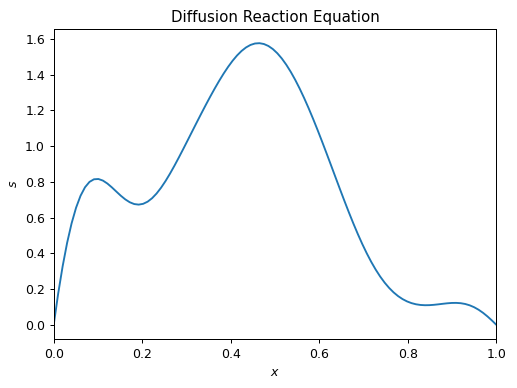

In [10]:
key = random.PRNGKey(123)
_, _, S0 = generate_test_data(key, 1, Nx)
S0 = S0.reshape((Nx,Nt))
x = jnp.linspace(0, 1, Nx)
t = jnp.linspace(0, 1, Nt)
# S = s_test.reshape(Nx,Nt)


fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
ax.plot(x, S0[-1])
ylim = plt.ylim()
xlim = [0, 1]
plt.tight_layout()



for i in range(Nt):
    ax.clear()
    ax.plot(x, S0[i])
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.xlabel(f'$x$')
    plt.ylabel(f'$s$')
    plt.title(f'Diffusion Reaction Equation')
    plt.tight_layout()
    fig.canvas.draw()



# Generate the Data

In [11]:
train_op, train_pde, train_bcs, train_ics = generate_training_data_efficient(key, N, N_op_train, N_pde_train, N_bcs_train, N_ics_train)

u_op, y_op, s_op, num_op  = train_op
u_pde, y_pde, s_pde, num_pde = train_pde
u_bcs, y_bcs, s_bcs, num_bcs = train_bcs
u_ics, y_ics, s_ics, num_ics  = train_ics

# Initialize model

In [12]:
branch_layers = [m, 50, 50, 50, 50, 50]
trunk_layers =  [2, 50, 50, 50, 50, 50]
model = DRDeepONetPI(branch_layers, trunk_layers, branch_net=modified_MLP, trunk_net=modified_MLP, ckpt_dir='DiffusionReaction/')

# Restore the model

In [13]:
model.restore()
model.restore_history()
model.loss_log

[[0.0, 2.7685487270355225],
 [10.0, 1.1023776531219482],
 [20.0, 0.9095937013626099],
 [30.0, 0.8406607508659363],
 [40.0, 0.815211296081543],
 [50.0, 0.7967809438705444],
 [60.0, 0.7885071635246277],
 [70.0, 0.7518165111541748],
 [80.0, 0.7365953922271729],
 [90.0, 0.7072139978408813],
 [100.0, 0.6843509078025818],
 [110.0, 0.6638595461845398],
 [120.0, 0.6560673713684082],
 [130.0, 0.6299450397491455],
 [140.0, 0.630386233329773],
 [150.0, 0.6009091734886169],
 [160.0, 0.5781271457672119],
 [170.0, 0.5766831636428833],
 [180.0, 0.5458592772483826],
 [190.0, 0.5279107093811035],
 [200.0, 0.5199060440063477],
 [210.0, 0.492933064699173],
 [220.0, 0.4907741844654083],
 [230.0, 0.4679342806339264],
 [240.0, 0.4705558717250824],
 [250.0, 0.46677038073539734],
 [260.0, 0.45568251609802246],
 [270.0, 0.4541638195514679],
 [280.0, 0.4398055970668793],
 [290.0, 0.4334973096847534],
 [300.0, 0.42300283908843994],
 [310.0, 0.41485950350761414],
 [320.0, 0.4074133038520813],
 [330.0, 0.384030163

# Create data set

In [14]:
batch_size = 10000
# op_dataset = DataGenerator(u_op, y_op, s_op, batch_size)
# pde_dataset = DataGenerator(u_pde, y_pde, s_pde, batch_size)
# bcs_dataset = DataGenerator(u_bcs, y_bcs, s_bcs, batch_size)
# ics_dataset = DataGenerator(u_ics, y_ics, s_ics, batch_size)
op_dataset = DataGeneratorEfficient(u_op, y_op, s_op, num_op, batch_size)
pde_dataset = DataGeneratorEfficient(u_pde, y_pde, s_pde, num_pde, batch_size)
bcs_dataset = DataGeneratorEfficient(u_bcs, y_bcs, s_bcs, num_bcs, batch_size)
ics_dataset = DataGeneratorEfficient(u_ics, y_ics, s_ics, num_ics, batch_size)

# Train then Network

In [17]:
model.train(op_dataset, pde_dataset, bcs_dataset, ics_dataset, nIter=35000)

 36%|███▌      | 36230/100000 [31:07<54:46, 19.41it/s, loss=0.00021760131, loss_operator=1.7650138e-05, loss_physics=0.00014191188, loss_bcs=2.5301486e-05, loss_ics=3.273781e-05]    


KeyboardInterrupt: 

# Save the Network

In [18]:
model.save()
model.save_history()

# Generate and Evaluate Test data

In [15]:
# Define number of samples and RNG
N_test = 100 # number of input samples 
m_test = m   # number of sensors 
key_test = random.PRNGKey(1234567)
keys_test = random.split(key_test, N_test)

# Predict
params = model.get_params(model.opt_state)

# Compute error
error_s = vmap(compute_error, (0, None))(keys_test, m_test) 
print('mean of relative L2 error of s: {:.2e}'.format(error_s.mean()))
print('std of relative L2 error of s: {:.2e}'.format(error_s.std()))

mean of relative L2 error of s: 9.53e-03
std of relative L2 error of s: 3.95e-03


# Plot for loss function

<IPython.core.display.Javascript object>


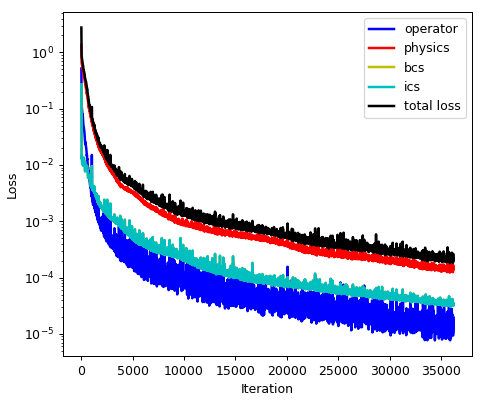

In [20]:
plt.figure(figsize = (6,5))
loss_operator_log = jnp.array(model.loss_operator_log)
loss_physics_log = jnp.array(model.loss_physics_log)
loss_bcs_log = jnp.array(model.loss_bcs_log)
loss_ics_log = jnp.array(model.loss_ics_log)
loss_log = jnp.array(model.loss_log)

plt.plot(loss_operator_log[:,0], loss_operator_log[:,1], 'b-', lw=2, label='operator')
plt.plot(loss_physics_log[:,0], loss_physics_log[:,1], 'r-', lw=2, label='physics')
plt.plot(loss_bcs_log[:,0], loss_bcs_log[:,1], 'y-', lw=2, label='bcs')
plt.plot(loss_ics_log[:,0], loss_ics_log[:,1], 'c-', lw=2, label='ics')
plt.plot(loss_log[:,0], loss_log[:,1], 'k-', lw=2, label='total loss')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

# Generate one test sample

In [21]:
key = random.PRNGKey(12345)
# key = random.PRNGKey(112312347)
P_test = 100
Nx = m
u_test, y_test, s_test = generate_test_data(key, 1, P_test)

# Predict

In [22]:
params = model.get_params(model.opt_state)
s_pred = model.predict_s(params, u_test, y_test)

# Compute Error

In [23]:
# Generate an uniform mesh
x = jnp.linspace(0, 1, Nx)
t = jnp.linspace(0, 1, Nt)
XX, TT = jnp.meshgrid(x, t)

# Grid data
S_pred = griddata(y_test, s_pred.flatten(), (XX,TT), method='cubic')
S_test = griddata(y_test, s_test.flatten(), (XX,TT), method='cubic')

# Compute the relative l2 error 
error = jnp.linalg.norm(S_pred - S_test, 2) / jnp.linalg.norm(S_test, 2) 
print('Relative l2 error: {:.3e}'.format(error))

Relative l2 error: 6.092e-03


<IPython.core.display.Javascript object>


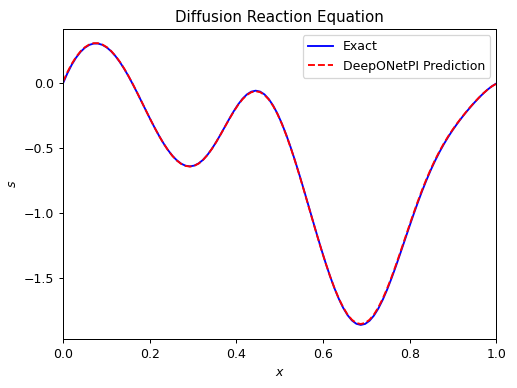

In [24]:
# key = random.PRNGKey(123)
# _, _, S0 = generate_test_data(key, 1, Nx)
# S0 = S0.reshape((Nx,Nt))
# x = jnp.linspace(0, 1, Nx)
# t = jnp.linspace(0, 1, Nt)
# S = s_test.reshape(Nx,Nt)


fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
ax.plot(x, S_test[-1], 'b-', label='Exact')
ax.plot(x, S_pred[-1], 'r--', label='DeepONetPI Prediction')
ylim = plt.ylim()
xlim = [0, 1]
plt.tight_layout()



for i in range(Nt):
    ax.clear()
    ax.plot(x, S_test[i], 'b-', label='Exact')
    ax.plot(x, S_pred[i], 'r--', label='DeepONetPI Prediction')
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.xlabel(f'$x$')
    plt.ylabel(f'$s$')
    plt.title(f'Diffusion Reaction Equation')
    plt.legend(loc='upper right')
    plt.tight_layout()
    fig.canvas.draw()


# Plot Predictions and True Values

<IPython.core.display.Javascript object>


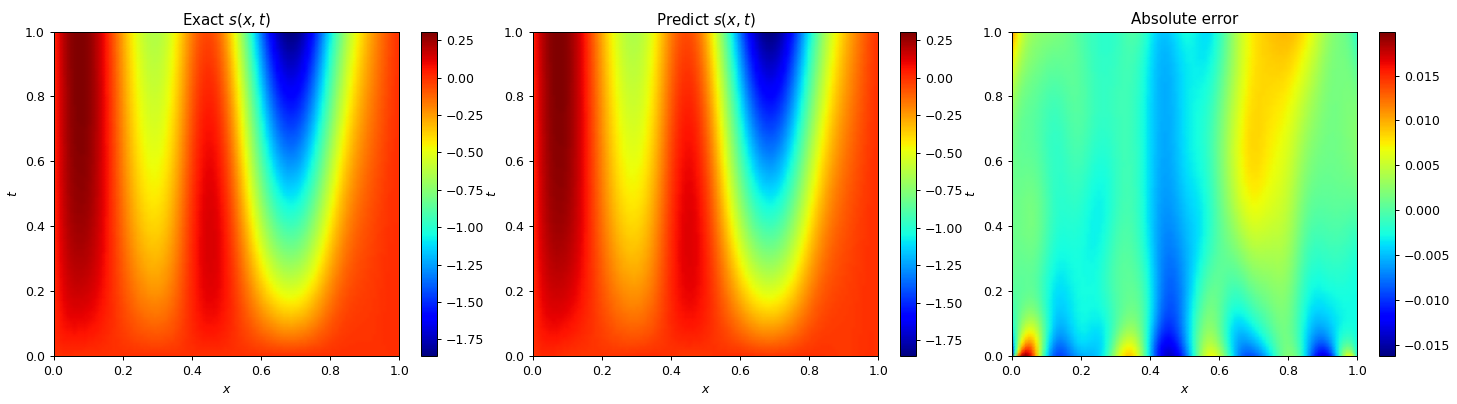

In [25]:
fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
# plt.pcolor(XX,TT, S_test, cmap='jet')
plt.pcolormesh(XX,TT, S_test, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Exact $s(x,t)$')
plt.tight_layout()

plt.subplot(1,3,2)
# plt.pcolor(XX,TT, S_pred, cmap='jet')
plt.pcolormesh(XX,TT, S_pred, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Predict $s(x,t)$')
plt.tight_layout()

plt.subplot(1,3,3)
# plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
plt.pcolormesh(XX,TT, S_pred - S_test, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()

In [26]:
def plot_predictions(key, S_test, Nx=100, Nt=100, save_path=None):
#     if print_index:
#         display(sind)
    u_test, y_test, s_test = generate_test_data(key, 1, Nx)
    params = model.get_params(model.opt_state)
    s_pred = model.predict_s(params, u_test, y_test)
#     s_test_ = S_test[sind]

    # Predict
    params = model.get_params(model.opt_state)
    s_pred = model.predict_s(params, u_test, y_test)

    # Generate an uniform mesh
    x = jnp.linspace(0, 1, Nx)
    t = jnp.linspace(0, 1, Nt)
    XX, TT = jnp.meshgrid(x, t)

    # Grid data
    # S_pred = griddata(y_test, s_pred.flatten(), (XX,TT), method='cubic')
    # S_true = griddata(y_test, s_test.flatten(), (XX,TT), method='cubic')
    # S_true = s_test_
    S_true = s_test.reshape(Nx,Nt)
    S_pred = s_pred.reshape(Nx,Nt)
    u = u_test[0]
    
    # Plot
    fig = plt.figure(figsize=(23,5))

    plt.subplot(1,4,1)
    plt.plot(x, u)
    plt.xlabel('$x$')
    plt.ylabel('$u$')
    plt.title('Source Term $u(x)$')
    plt.xlim([0,1])
    plt.tight_layout()


    plt.subplot(1,4,2)
    plt.pcolormesh(XX,TT, S_true, cmap='jet', shading='gouraud')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$t$')
    plt.title('Exact $s(x,t)$')
    plt.tight_layout()
    plt.axis('square')


    plt.subplot(1,4,3)
    plt.pcolormesh(XX,TT, S_pred, cmap='jet', shading='gouraud')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$t$')
    plt.title('Predict $s(x,t)$')
    plt.tight_layout()
    plt.axis('square')

    plt.subplot(1,4,4)
    # plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
    plt.pcolormesh(XX,TT, S_pred - S_true, cmap='jet', shading='gouraud')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$t$')
    plt.title('Absolute error')
    plt.tight_layout()
    plt.axis('square')

    if save_path is not None:
        plt.savefig(f'{save_path}.png', bbox_inches='tight')
    plt.show()

    


In [28]:

figures_dir = 'DiffusionReaction/figures/'
os.makedirs(figures_dir, exist_ok=True)

<IPython.core.display.Javascript object>


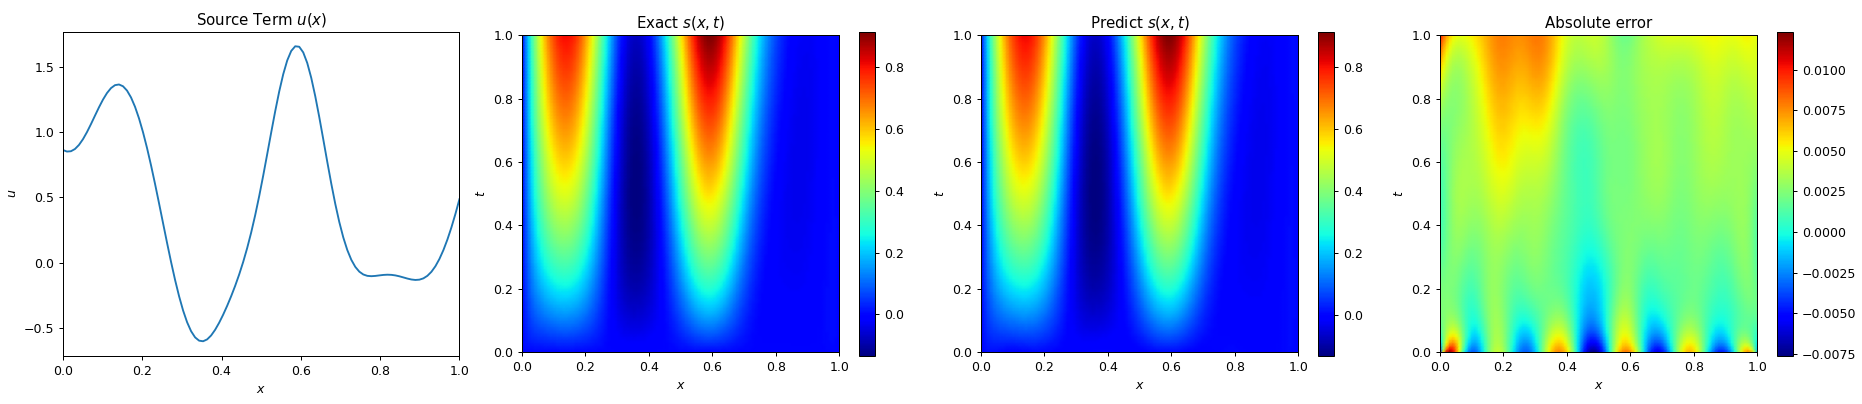

<IPython.core.display.Javascript object>


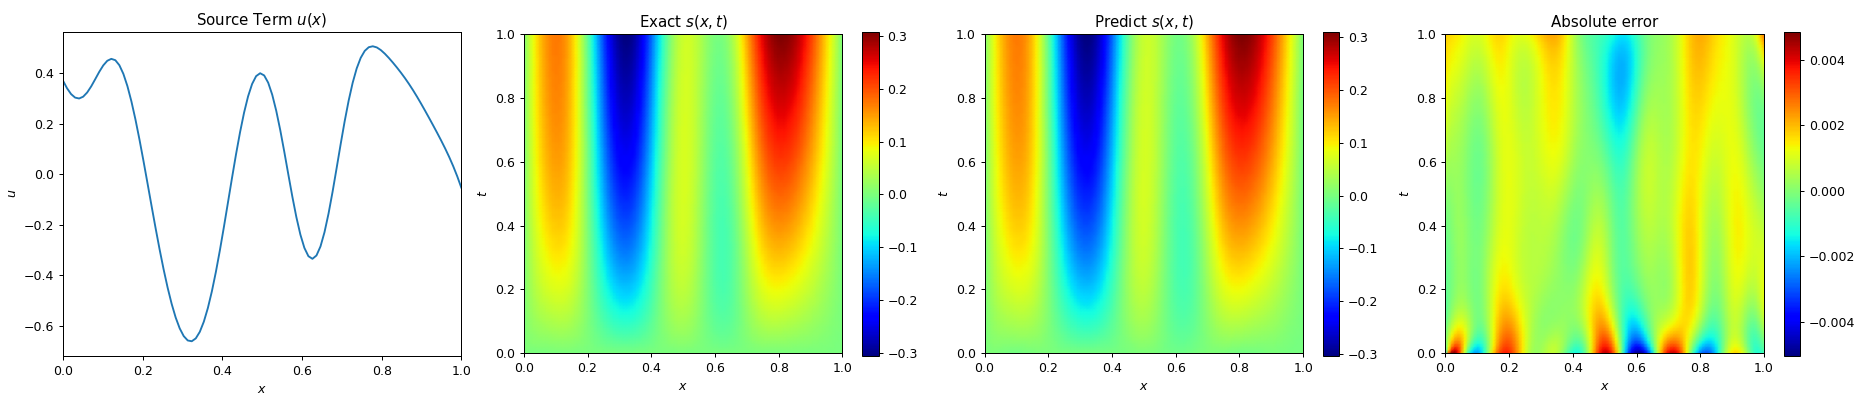

<IPython.core.display.Javascript object>


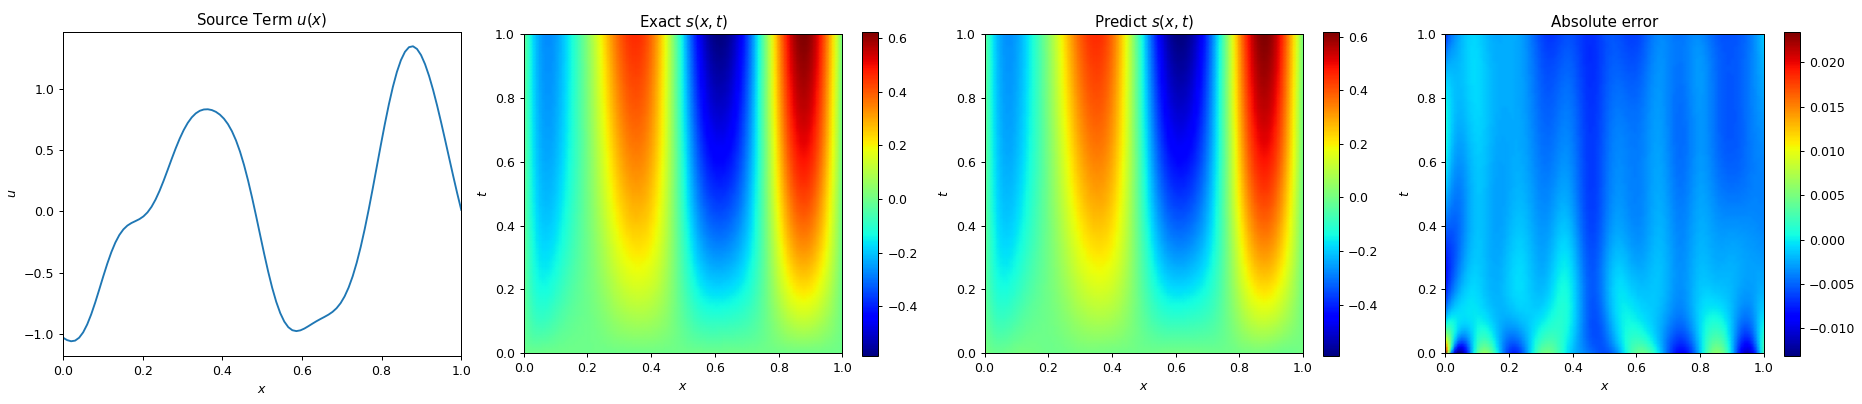

<IPython.core.display.Javascript object>


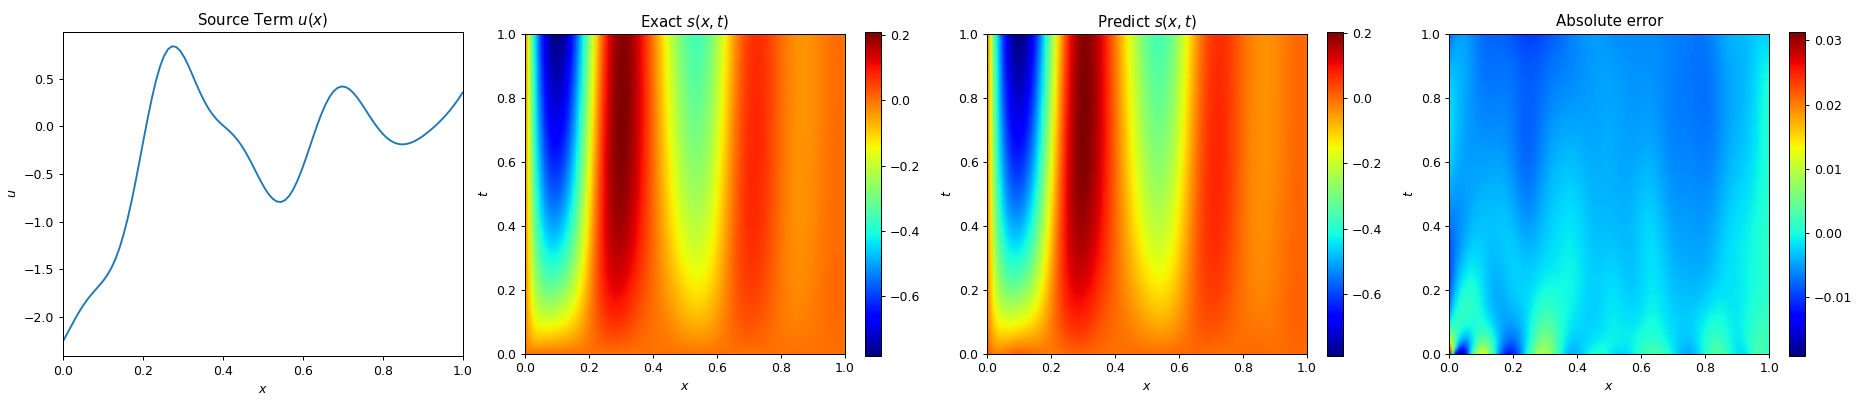

<IPython.core.display.Javascript object>


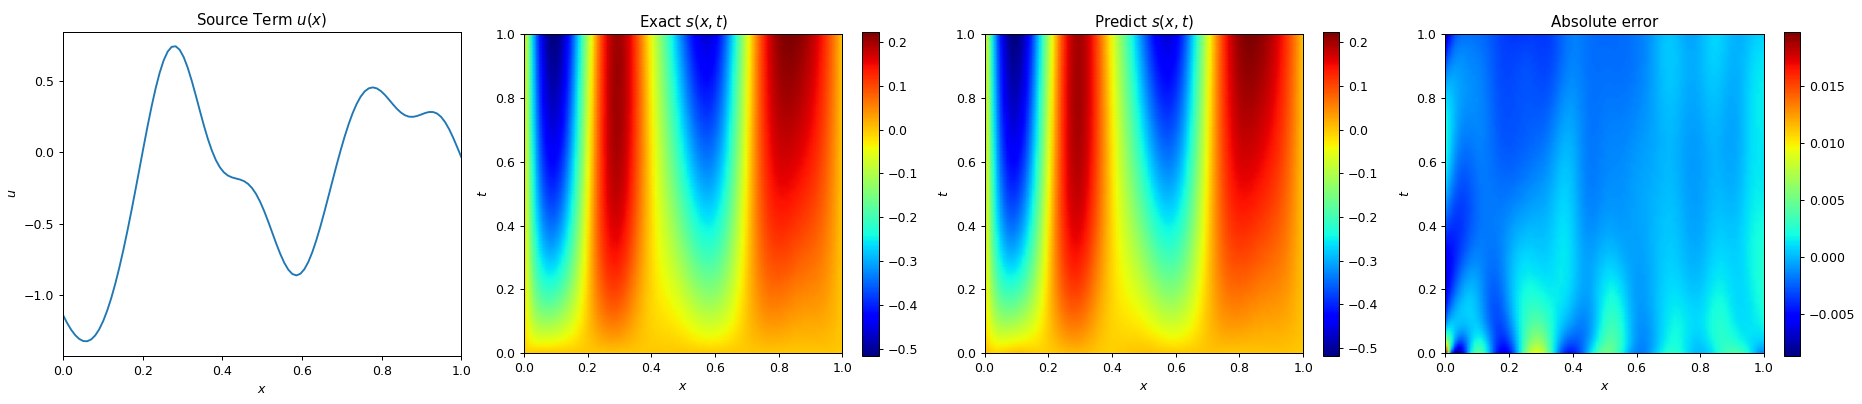

In [29]:
num_plots = 5
key = random.PRNGKey(0)
keys = random.split(key, num_plots)
for i, subkey in enumerate(keys):
    save_path = os.path.join(figures_dir, f'DiffusionReaction{i}')
#     plot_predictions(subkey, S_test, Nx=100, Nt=100, save_path=save_path)
    plot_predictions(subkey, S_test, Nx=100, Nt=100, save_path=None)